In [134]:
import torch
import pandas as pd
import numpy as np

In [135]:
# from ucimlrepo import fetch_ucirepo 
  
# # fetch dataset 
# cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# # data (as pandas dataframes) 
# X = cdc_diabetes_health_indicators.data.features 
# y = cdc_diabetes_health_indicators.data.targets 
  
# # metadata 
# print(cdc_diabetes_health_indicators.metadata) 
  
# # variable information 
# print(cdc_diabetes_health_indicators.variables) 


In [136]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [137]:
X.info()
y.Diabetes_binary.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-null  int64
 15  PhysHlth              253680 non-n

array([0, 1], dtype=int64)

# tensor

In [138]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y.Diabetes_binary)
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [140]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

In [141]:
trainset = TensorDataset(X_train, y_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = TensorDataset(X_test, y_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

print(f"Train set size: {len(trainset)}")
print(f"Test set size: {len(testset)}")
y_train.size()

Train set size: 202944
Test set size: 50736


torch.Size([202944, 1])

# Model neural network

In [142]:
from torch import nn, optim

In [143]:
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4, 1),
    nn.Sigmoid()).to(device)
model

Sequential(
  (0): Linear(in_features=21, out_features=32, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=16, out_features=8, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=8, out_features=4, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=4, out_features=1, bias=True)
  (13): Sigmoid()
)

In [144]:
criterion = nn.BCELoss().to(device)

In [145]:
optimizer = optim.RAdam(model.parameters(), lr=0.001)

In [146]:
trainloader.dataset.tensors[1].shape

torch.Size([202944, 1])

# train loop

In [ ]:
epochs = 1000
train_cost, test_cost = [], []
for epoch in range(epochs):
    model.train()
    cost = 0.0
    for features, targets in trainloader:
        output = model(features)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        cost += loss.item() * features.size(0)
    cost /= len(trainloader.dataset)
    train_cost.append(cost)

    with torch.no_grad():
        model.eval()
        tcost = 0.0
        for features, targets in testloader:
            output = model(features)
            loss = criterion(output, targets)
            tcost += loss.item() * features.size(0)
        tcost/= len(testloader.dataset)
        test_cost.append(tcost)
        print(f"\rEpoch {epoch+1}/{epochs}, Train Loss: {train_cost[-1]:.4f} - Test Loss: {test_cost[-1]:.4f}", end='')


Epoch 1/1000, Train Loss: 0.3854 - Test Loss: 0.3301

# Cost History

In [ ]:
test_cost

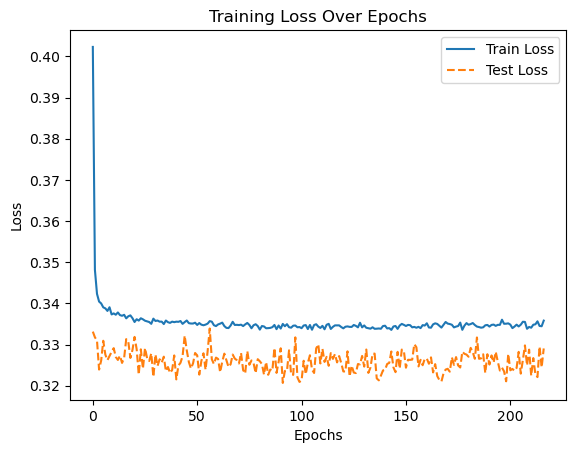

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_cost, label='Train Loss', linestyle='-')
plt.plot(test_cost, label='Test Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
import os 

In [ ]:
os.makedirs('models', exist_ok=True)

In [ ]:
torch.save(model.state_dict(), 'models/house_pred_model.pth')

In [ ]:
log = {
    'train_cost': train_cost,
    'test_cost': test_cost,
    'epochs': epochs,
    'optimizer_state_dict': optimizer.state_dict()
}
torch.save(log, 'models/house_pred_log.pth')

# Load model

In [ ]:
weight = torch.load('models/house_pred_model.pth')
model.load_state_dict(weight, map_location=torch.device('cpu'))

# class

In [ ]:
def loop_fn(mode, dataloader, model, criterion, optimizer=None, device='cpu'):
    """
    A function to run a training or testing loop for a model.
    Args:
        mode (str): 'train' or 'test'.
        dataloader (DataLoader): DataLoader for the dataset.
        model (nn.Module): The model to train or test.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer, optional): Optimizer for training. Defaults to None.
        device (str, optional): Device to run the model on ('cpu' or 'cuda'). Defaults to 'cpu'.
    Returns:
        list: A tuple containing the average loss and accuracy.
    """
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost , correct = 0.0, 0.0
    for features, targets in dataloader:
        features, targets = features.to(device), targets.to(device)
        output = model(features)
        loss = criterion(output, targets)

        if mode == 'train':
            # optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * features.size(0)
        correct += features.size(0)

    cost /= len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)

    return cost, accuracy

In [ ]:
class HousePredictionModel(nn.Module):
    def __init__(self):
        super(HousePredictionModel, self).__init__( )
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)